# Pontifícia Universidade Católica do Paraná

#### Atividade Somativa 2
#### Aluno: Rafael Oliveira Tavares Pinto
#### Disciplina: Técnicas de Machine Learning

## Introdução

Seoul Bike Data é o dataset a ser analisado nesse trabalho. O dataset contém a quantidade de bicicletas alugadas na cidade de Seul, capital da Coréia do Sul, entre os anos de 2017 e 2018. 
O objetivo desse trabalho é o de analisar e usar as informações mais relevantes retiradas do dataset para realizar uma análise preditiva prevendo a quantidade de bicicletas que serão alugadas com base em variáveis climáticas e temporais.
O problema é de regressão supervisionada, pois queremos prever um valor numérico (quantidade de bicicletas alugadas).

Começamos o processo importando as bibliotecas do python a serem utilizadas em nossas análises:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

In [2]:
%matplotlib inline

## Dataset Seoul Bike Data

A seguir leremos o arquivo do dataset em formato excel utilizando a biblioteca pandas e exibiremos as primeiras e últimas instâncias do dataset:

In [3]:
df_bike = pd.read_excel('seoul_bike_data.xlsx')
df_bike

,DateTime,Day,Weekday,Hour,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
0,2017-01-12 00:00:00,12,5,0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0
1,2017-01-12 01:00:00,12,5,1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0
2,2017-01-12 02:00:00,12,5,2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0
3,2017-01-12 03:00:00,12,5,3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0
4,2017-01-12 04:00:00,12,5,4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,31,2,19,163,0.0,31,2.2,2000,-15.1,0.0,0.0,0.0
8756,2018-12-31 20:00:00,31,2,20,161,-1.0,32,0.9,2000,-15.6,0.0,0.0,0.0
8757,2018-12-31 21:00:00,31,2,21,179,-1.6,35,1.0,2000,-15.1,0.0,0.0,0.0
8758,2018-12-31 22:00:00,31,2,22,155,-2.1,36,1.7,2000,-15.2,0.0,0.0,0.0


Aqui criamos um mapa de calor para mostrar a correlação entre os atributos:

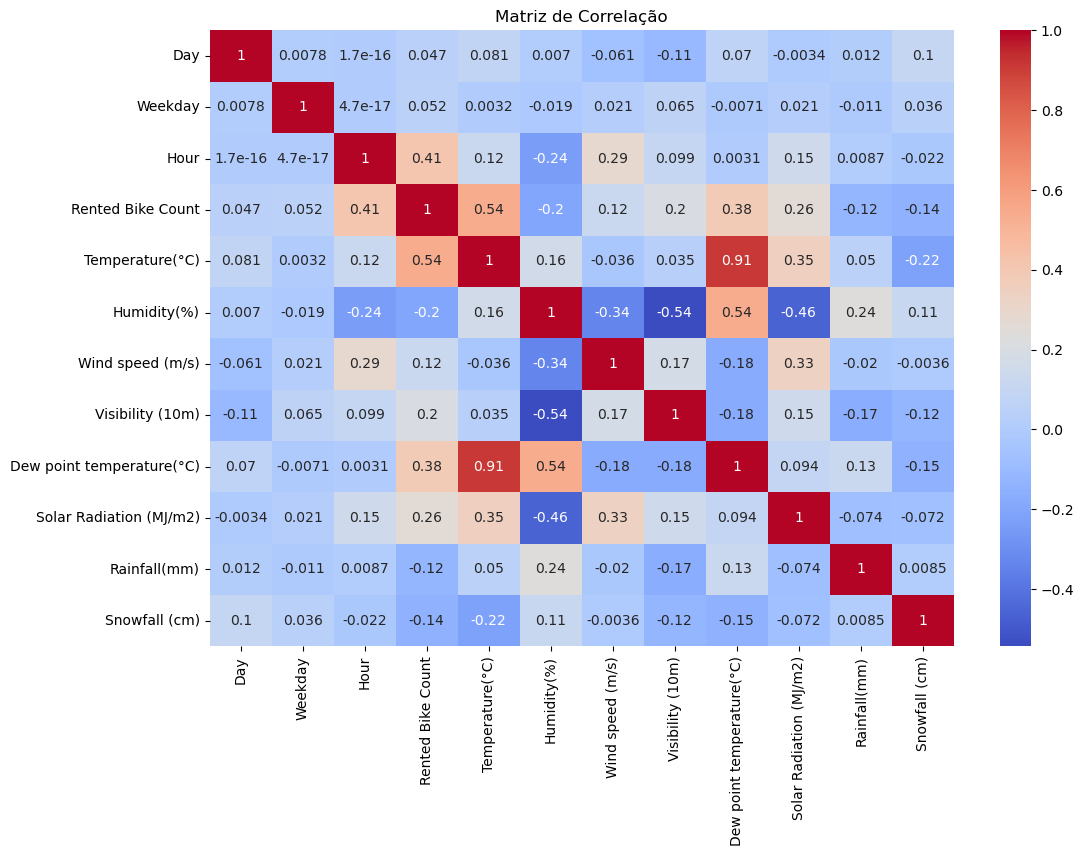

In [4]:
df_corr = df_bike.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12,8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

## Separação entre treino e teste

Antes de qualquer pré-processamento, dividimos o dataset entre dados de treino e de teste:

In [5]:
X = df_bike.drop(columns=["Rented Bike Count"])
y = df_bike["Rented Bike Count"]

X_numerico = X.select_dtypes(include=["float64", "int64"])

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_numerico, y, test_size=0.25, random_state=42)

## Criação dos Pipelines

Aqui criamos dois pipelines que reúnem escalonamento dos dados, redução de dimensionalidade e o modelo de regressão:

In [6]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('regressor', LinearRegression())
])

pipeline_rf_base = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('regressor', RandomForestRegressor(random_state=42))
])

## Ajuste de hiperparâmetros

Utilizado GridSearchCV para Random Forest:

In [7]:
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, None],
    'regressor__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline_rf_base, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_raw, y_train)

pipeline_lr.fit(X_train_raw, y_train)
pred_lr = pipeline_lr.predict(X_test_raw)

best_model_rf = grid_search.best_estimator_
pred_rf = best_model_rf.predict(X_test_raw)

## Avaliando os modelos

Usamos métricas como MAE e RMSE para avaliar a performance preditiva de cada modelo com base nas previsões do pipeline. O modelo Random Forest passou por ajuste de hiperparâmetros com GridSearchCV:

In [8]:
def avaliar_modelo(y_test, pred, nome):
    print(f"\nModelo: {nome}")
    print("MAE:", mean_absolute_error(y_test, pred))
    print("RMSE:", root_mean_squared_error(y_test, pred))

avaliar_modelo(y_test, pred_lr, "Linear Regression")
avaliar_modelo(y_test, pred_rf, "Random Forest (GridSearch)")


Modelo: Linear Regression
MAE: 377.61619181953836
RMSE: 512.8091497775149

Modelo: Random Forest (GridSearch)
MAE: 281.6451187214612
RMSE: 411.1204484428546


## Comparando visualmente

O gráfico abaixo compara visualmente os valores reais e os previstos por cada modelo:

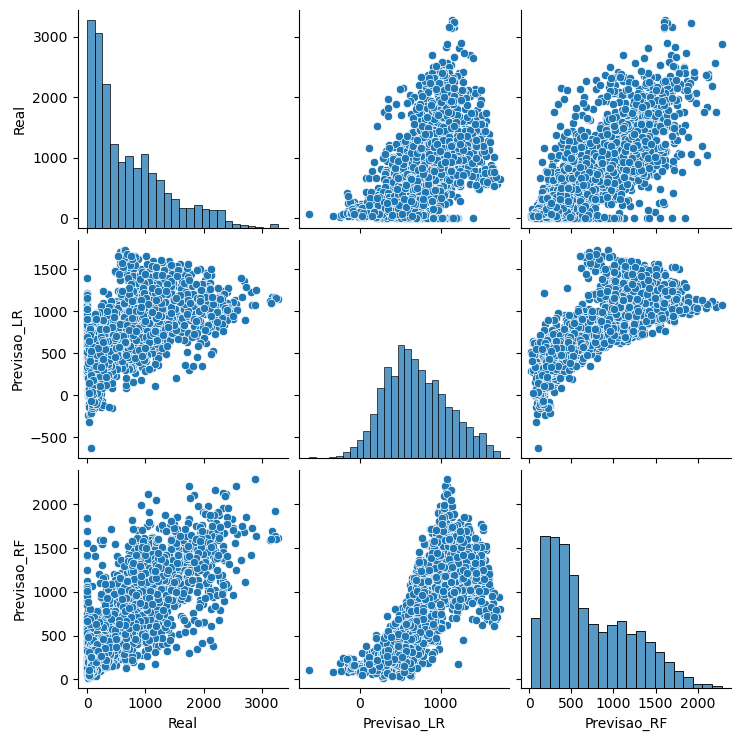

In [9]:
df_resultado = pd.DataFrame({
    "Real": y_test.values,
    "Previsao_LR": pred_lr,
    "Previsao_RF": pred_rf
})

sns.pairplot(df_resultado)
plt.show()

## Conclusões

O modelo de Random Forest com ajuste de hiperparâmetros (GrindSearchCV) apresentou melhor desempenho que o modelo de regressão linear. Isso é perceptível dado os valores menores de MAE e RSME.